# Importing The Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control 
import tensorflow as tf

# Calculate Routh-Hourwitz Criterion

In [8]:
#Class to call RH_Criterion
class RH_Criterion:

    def __init__(self,coeff,s1_matrice,s2_matrice):
        
        #Input Coeff's (Up to 2nd order)
        self.coeff = coeff        #initialize coeffs
        self.s1_matrice = s1_matrice   #set for s1 coeffs
        self.s2_matrice = s2_matrice   #set for s2 coeffs
        self.s3_matrice = [-np.linalg.det([s1_matrice,s2_matrice])/coeff[1], 0] #set for s3 coeffs

        #Return Value
        self.CalculateRH = self.Calculate_RH(self.coeff,
                                             self.s1_matrice,
                                             self.s2_matrice,
                                             self.s3_matrice)
    
    def Calculate_RH(self,coeff,s1_matrice,s2_matrice,s3_matrice):
        
        #Identify the criterion
        Rhcriterion = []
        if (s1_matrice[0],s2_matrice[0],s3_matrice[0] > 0 | s1_matrice[0],s2_matrice[0],s3_matrice[0] < 0):
            Rhcriterion.append("this system is stable")
        else:
            Rhcriterion.append("this system is not stable")

        #Calculate the discriminant
        Determinant = (coeff[1]**2) - (4*coeff[0]*coeff[2])

        return Rhcriterion,Determinant

if __name__ == "__main__":

    #Input Coeff's (Up to 2nd order)
    coeff = ([20,0.5,0.01])         #initialize coeffs
    s1_matrice = [coeff[0],coeff[2]]   #set for s1 coeffs
    s2_matrice = [coeff[1],0]   #set for s2 coeffs
    s3_matrice = [-np.linalg.det([s1_matrice,s2_matrice])/coeff[1], 0] #set for s3 coeffs

    print(RH_Criterion(coeff,s1_matrice,s2_matrice).CalculateRH)

(['this system is stable'], -0.55)


# Calculate Root Locus


          1
---------------------
20 s^2 + 0.5 s + 0.01

(array([[-0.0125-1.85404962e-02j, -0.0125+1.85404962e-02j],
       [-0.0125-1.85404962e-02j, -0.0125+1.85404962e-02j],
       [-0.0125-1.90703919e-02j, -0.0125+1.90703919e-02j],
       ...,
       [-0.0125-3.16233201e+00j, -0.0125+3.16233201e+00j],
       [-0.0125-1.00000172e+01j, -0.0125+1.00000172e+01j],
       [-0.0125-3.16227820e+01j, -0.0125+3.16227820e+01j]]), array([0.00000000e+00, 0.00000000e+00, 3.98596939e-04, ...,
       2.00000000e+02, 2.00000000e+03, 2.00000000e+04]))

          1
---------------------
20 s^2 + 0.5 s + 0.01

(array([[-0.0125-1.85404962e-02j, -0.0125+1.85404962e-02j],
       [-0.0125-1.85404962e-02j, -0.0125+1.85404962e-02j],
       [-0.0125-1.90703919e-02j, -0.0125+1.90703919e-02j],
       ...,
       [-0.0125-3.16233201e+00j, -0.0125+3.16233201e+00j],
       [-0.0125-1.00000172e+01j, -0.0125+1.00000172e+01j],
       [-0.0125-3.16227820e+01j, -0.0125+3.16227820e+01j]]), array([0.00000000e+00, 0.0000

(<Axes: title={'center': 'Root Locus'}, xlabel='real part', ylabel='imaginary part'>,
 <Axes: title={'center': 'Impulse Response'}, xlabel='Time (s)', ylabel='Amplitude'>,
 <Axes: title={'center': 'FFT Algorithm'}, xlabel='Amplitude', ylabel='Spectral Amplitude'>,
 None)

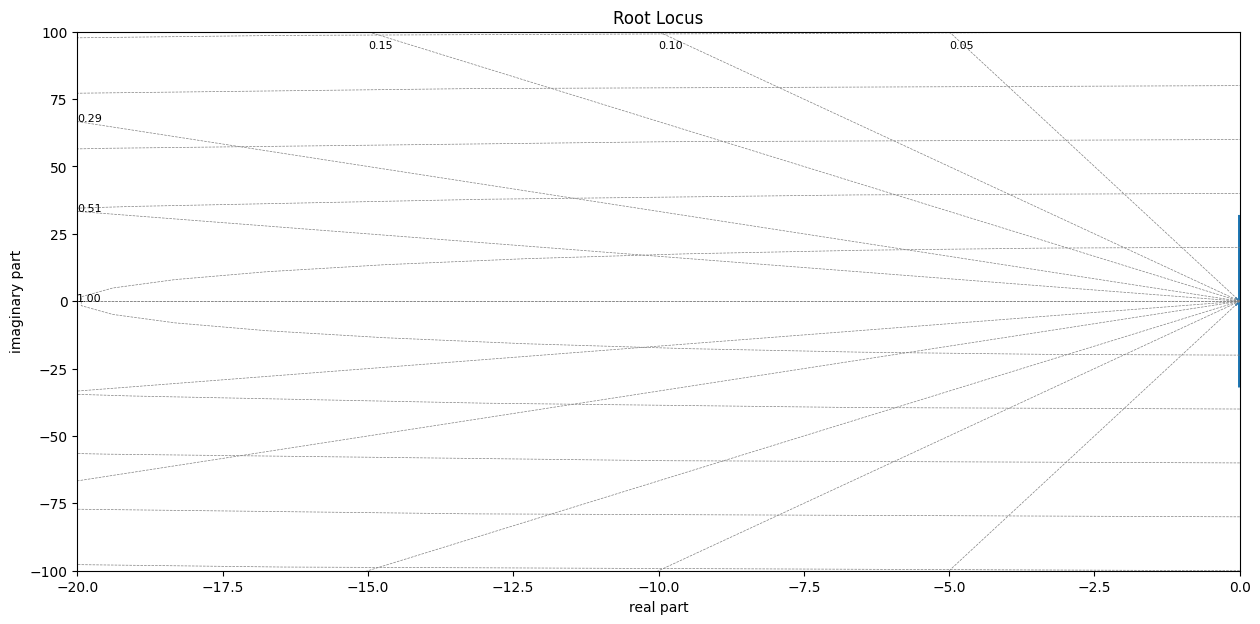

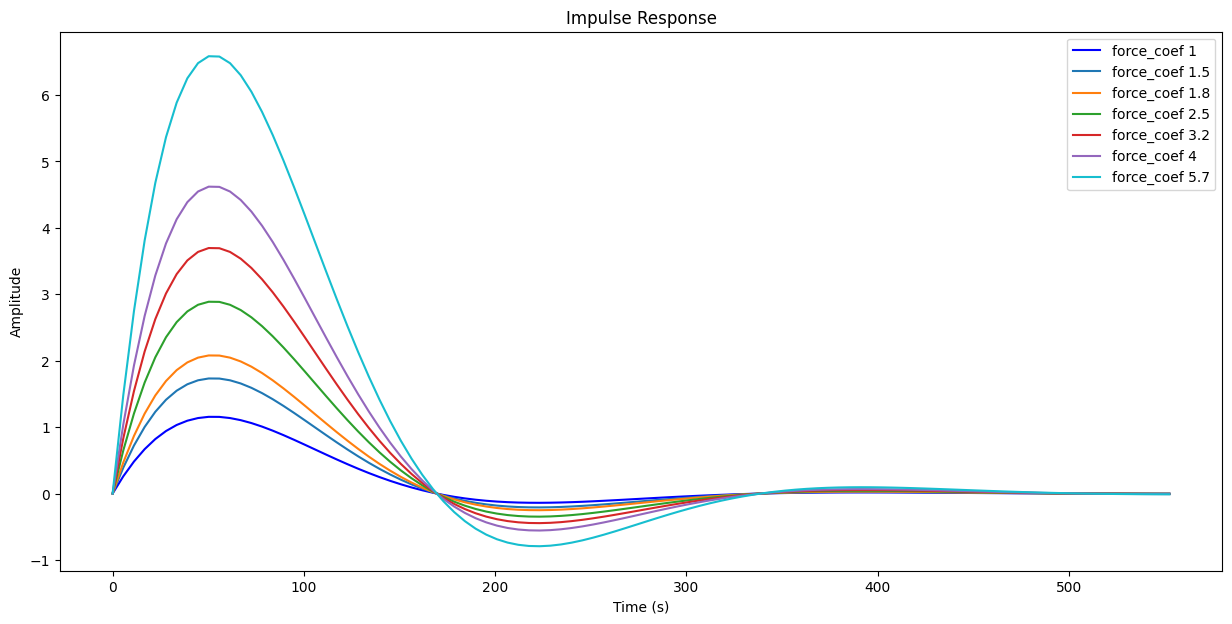

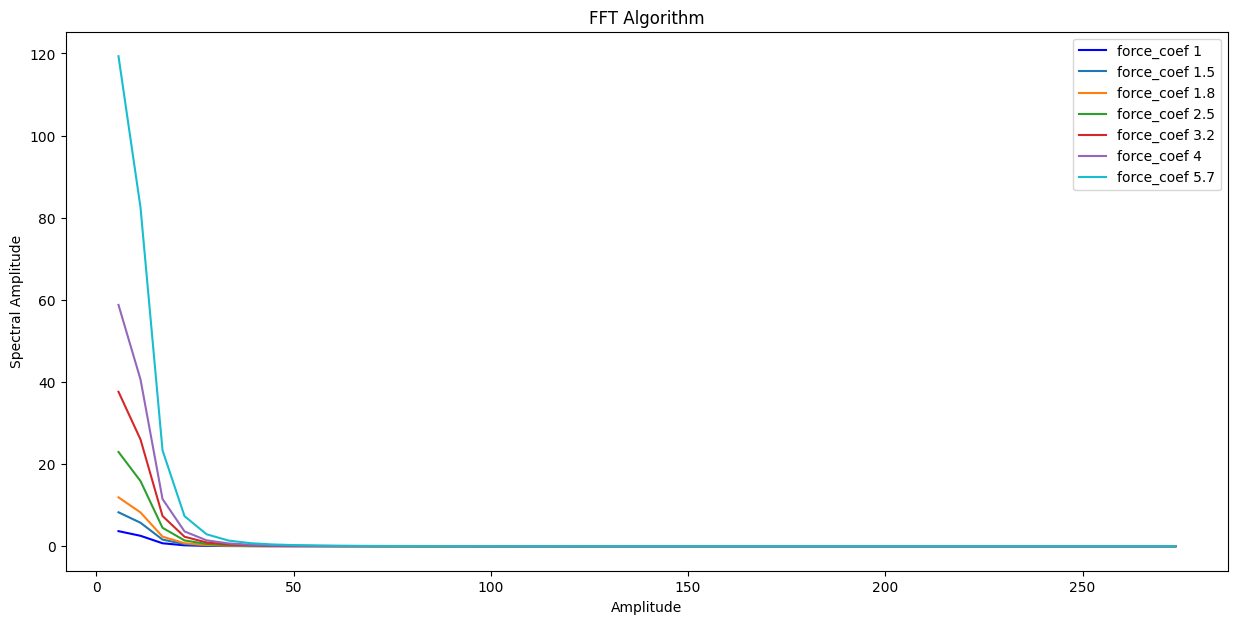

In [25]:
def Transfer_function(coeff):
    
    force_coef = [1,1.5,1.8,2.5,3.2,4,5.7]
    color = ['b','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf']
    transfer_function = control.TransferFunction([1],coeff)

    fig,ax = plt.subplots(figsize = (15,7))
    rlist, klist = control.rlocus(transfer_function, xlim=[-20,0], ylim=[-100,100])
    ax.set_xlabel("real part")
    ax.set_ylabel("imaginary part")
    ax.set_title("Root Locus")

    time, response = control.impulse_response(transfer_function)
    dt = 0.001
    PSD_I = []
    n = len(time)
    for i in force_coef:
        fhat = np.fft.fft(i*response,n)
        PSD = fhat * np.conj(fhat) / n                     # Power spectral density (power per frequency)(important)
        PSD_I.append(PSD)
    freq = (1 / (dt * n)) * np.arange(n)               # Create x-axis of frequencies
    L = np.arange(1, n/2, dtype='int')               # Only plot the first half  
    print(f'{transfer_function}\n{control.rlocus(transfer_function,plot=False)}')

    fig.savefig("Root Locus")


    fig,bx = plt.subplots(figsize = (15,7))

    for i in range (0,len(force_coef)):

        bx.plot(time, force_coef[i]*response, color = color[i], label = f'force_coef {force_coef[i]}')
        bx.set_title("Impulse Response")
        bx.set_xlabel("Time (s)")
        bx.set_ylabel("Amplitude")
        bx.legend()
    
    fig.savefig("Time Respond(s)")

    fig,cx = plt.subplots(figsize = (15,7))
    for i in range (0,len(force_coef)):
        cx.plot(time[L],PSD_I[i][L], color = color[i], label = f'force_coef {force_coef[i]}')
        cx.set_title("FFT Algorithm")
        cx.set_xlabel("Amplitude")
        cx.set_ylabel("Spectral Amplitude")
        cx.legend()
    
    fig.savefig("FFT Analysis")
    return ax,bx,cx,print(f'{transfer_function}\n{control.rlocus(transfer_function,plot=False)}')

Transfer_function(coeff)
